# GDP Analysis: Machine Learning

In [1]:
# Import Dependencies
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import sqlalchemy
from config import pgadmin_password
from sqlalchemy import create_engine
import psycopg2
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix


## Data Selection

### Connecting to PostgreSQL

In [2]:
# Import Postgres username, password, and database name
from sqlalchemy import create_engine

postgres_address = 'localhost'
postgres_port = '5432' 
postgres_username = 'postgres'
postgres_password = pgadmin_password
postgres_dbname = 'GDP_economics'
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=postgres_username,
                        password=postgres_password,
                        ipaddress=postgres_address,
                        port=postgres_port,
                        dbname=postgres_dbname))
# Create the connection
cnx = create_engine(postgres_str)

### Loading Dataset

In [3]:
# Creating df for summary_gdp SQL table
economy_df= pd.read_sql_query('''SELECT * FROM countries;''', cnx)
economy_df

,country_id,country_code,economy,region
0,1,AFG,Afghanistan,South Asia
1,2,ALB,Albania,Europe & Central Asia
2,3,DZA,Algeria,Middle East & North Africa
3,4,ARG,Argentina,Latin America & Caribbean
4,5,ARM,Armenia,Europe & Central Asia
...,...,...,...,...
151,152,VEN,Venezuela (Bolivarian Rep. of),Latin America & Caribbean
152,153,VNM,Viet Nam,East Asia & Pacific
153,154,YEM,Yemen,Middle East & North Africa
154,155,ZMB,Zambia,Sub-Saharan Africa


In [4]:
# Creating df for summary_gdp SQL table
summary_gdp_df= pd.read_sql_query('''SELECT * FROM summary_gdp;''', cnx)
summary_gdp_df

,country_code,economy,region,years,tech_overall_index,ict,skills,research_dev,industry_activity,finance_access,...,productivity_over_index,human_capital,natural_capacity,energy,transport,info_comm_tech,institutions,private_sector,structural_change,coft_id
0,AFG,Afghanistan,South Asia,2008,0.072075,0.103354,0.170865,0.000000,0.331855,0.242233,...,18.823282,31.094856,58.485536,22.258151,8.488684,3.577535,15.947558,54.600186,14.723942,1
1,AFG,Afghanistan,South Asia,2009,0.071051,0.079601,0.165315,0.000000,0.401368,0.308691,...,19.255622,32.643189,58.328269,23.138830,8.760733,3.879257,15.463749,53.510755,15.254662,2
2,AFG,Afghanistan,South Asia,2010,0.096194,0.078095,0.156798,0.000000,0.435488,0.310786,...,19.380531,33.306044,58.486524,23.272956,8.972955,3.836936,16.084957,51.441468,15.411381,3
3,AFG,Afghanistan,South Asia,2011,0.123014,0.087214,0.151915,0.000000,0.358647,0.323599,...,19.844802,33.294867,58.243822,24.590893,8.958996,4.160740,16.593136,51.107480,15.956214,4
4,AFG,Afghanistan,South Asia,2012,0.052903,0.074048,0.154567,0.055488,0.343089,0.161664,...,20.460732,34.443517,58.087595,24.901164,8.905547,4.308839,20.446555,51.082891,15.383048,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700,ZWE,Zimbabwe,Sub-Saharan Africa,2014,0.076351,0.055848,0.173870,0.033890,0.307966,0.402475,...,22.190927,36.609360,53.354918,18.090417,11.175905,6.004241,25.011301,54.870738,18.070516,1701
1701,ZWE,Zimbabwe,Sub-Saharan Africa,2015,0.151292,0.192407,0.157911,0.086122,0.318435,0.380626,...,23.216091,37.122268,53.444351,18.039870,13.354525,6.481303,27.626012,54.925469,17.953966,1702
1702,ZWE,Zimbabwe,Sub-Saharan Africa,2016,0.136554,0.191800,0.156142,0.084610,0.297645,0.370459,...,23.358450,37.595356,53.444547,18.039870,14.080024,6.447096,27.623928,54.806645,17.790780,1703
1703,ZWE,Zimbabwe,Sub-Saharan Africa,2017,0.135447,0.272719,0.135707,0.107108,0.243774,0.378796,...,23.605561,37.982348,53.592981,17.872891,14.073782,6.858564,27.636091,54.346980,18.278227,1704


In [5]:
# Sorting for Chile Analysis (Chile_2018 =) 
economy_df.loc[(economy_df["country_code"] == "SLV")]

,country_id,country_code,economy,region
45,46,SLV,El Salvador,Latin America & Caribbean


In [6]:
# Sorting for Chile Analysis (Chile_2018 =) 
summary_gdp_df.loc[(summary_gdp_df["country_code"] == "SLV") & (
    summary_gdp_df["years"] == 2018), :]

,country_code,economy,region,years,tech_overall_index,ict,skills,research_dev,industry_activity,finance_access,...,productivity_over_index,human_capital,natural_capacity,energy,transport,info_comm_tech,institutions,private_sector,structural_change,coft_id
505,SLV,El Salvador,Latin America & Caribbean,2018,0.283017,0.298019,0.270975,0.101121,0.539916,0.644874,...,32.424237,47.155714,58.088033,27.748355,17.80703,10.430256,49.995116,81.899932,21.135004,506


In [7]:
# Modifying Chile 2018 data to reflect increases in research_dev by 15%
#summary_gdp_df.at[505, 'skills']= (0.270975/0.85)

### Data Preprocessing and EDA

In [8]:
# Removing SQL unique identifiers and GDP per capita (redundancy with GDP) columns
summary_gdp = summary_gdp_df.drop(['country_code','coft_id', 'gdp_per_capita_usdollars'], axis=1)

In [9]:
# df summary of information to find which features to encode
summary_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1705 entries, 0 to 1704
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   economy                  1705 non-null   object 
 1   region                   1705 non-null   object 
 2   years                    1705 non-null   int64  
 3   tech_overall_index       1705 non-null   float64
 4   ict                      1705 non-null   float64
 5   skills                   1705 non-null   float64
 6   research_dev             1705 non-null   float64
 7   industry_activity        1705 non-null   float64
 8   finance_access           1705 non-null   float64
 9   gdp_usdollars_millions   1705 non-null   float64
 10  productivity_over_index  1705 non-null   float64
 11  human_capital            1705 non-null   float64
 12  natural_capacity         1705 non-null   float64
 13  energy                   1705 non-null   float64
 14  transport               

In [10]:
# Binary encoding 'economy' and 'region' columns using LabelEncoder
le = LabelEncoder()
GDP_encoded = summary_gdp.copy()
columns=["economy", "region"]
GDP_encoded[columns] = summary_gdp[columns].apply(LabelEncoder().fit_transform)
GDP_encoded.head()
GDP_encoded[["economy", "region"]].value_counts()

economy  region
0        5         11
106      6         11
99       6         11
100      0         11
101      6         11
                   ..
52       6         11
53       6         11
54       1         11
55       1         11
154      6         11
Length: 155, dtype: int64

In [11]:
# Verifying if nulls are present
GDP_encoded.isnull().any()

economy                    False
region                     False
years                      False
tech_overall_index         False
ict                        False
skills                     False
research_dev               False
industry_activity          False
finance_access             False
gdp_usdollars_millions     False
productivity_over_index    False
human_capital              False
natural_capacity           False
energy                     False
transport                  False
info_comm_tech             False
institutions               False
private_sector             False
structural_change          False
dtype: bool

In [12]:
# Checking dtypes for encoded data
GDP_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1705 entries, 0 to 1704
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   economy                  1705 non-null   int32  
 1   region                   1705 non-null   int32  
 2   years                    1705 non-null   int64  
 3   tech_overall_index       1705 non-null   float64
 4   ict                      1705 non-null   float64
 5   skills                   1705 non-null   float64
 6   research_dev             1705 non-null   float64
 7   industry_activity        1705 non-null   float64
 8   finance_access           1705 non-null   float64
 9   gdp_usdollars_millions   1705 non-null   float64
 10  productivity_over_index  1705 non-null   float64
 11  human_capital            1705 non-null   float64
 12  natural_capacity         1705 non-null   float64
 13  energy                   1705 non-null   float64
 14  transport               

In [13]:
GDP_encoded.nunique()

economy                     155
region                        7
years                        11
tech_overall_index         1685
ict                        1670
skills                     1685
research_dev               1046
industry_activity          1686
finance_access             1685
gdp_usdollars_millions     1705
productivity_over_index    1705
human_capital              1703
natural_capacity           1688
energy                     1566
transport                  1666
info_comm_tech             1705
institutions               1694
private_sector             1669
structural_change          1670
dtype: int64

,economy,region,years,tech_overall_index,ict,skills,research_dev,industry_activity,finance_access,gdp_usdollars_millions,productivity_over_index,human_capital,natural_capacity,energy,transport,info_comm_tech,institutions,private_sector,structural_change
economy,1.000000e+00,1.722554e-02,-2.994019e-13,0.030757,0.025211,-0.007589,0.055647,0.061634,0.022893,0.064540,0.012057,-0.007946,0.078535,0.036639,0.016751,-0.024150,-0.008545,-0.008489,0.041375
region,1.722554e-02,1.000000e+00,-1.608117e-14,-0.584079,-0.571983,-0.615188,-0.431541,-0.411447,-0.497880,-0.095609,-0.598703,-0.602924,0.402961,-0.596815,-0.403853,-0.557717,-0.418548,-0.425743,-0.541819
years,-2.994019e-13,-1.608117e-14,1.000000e+00,0.064324,0.221652,-0.106611,0.089250,0.005721,-0.008973,0.024652,0.092237,0.085051,-0.036885,-0.003849,0.083683,0.178892,0.009612,0.003385,0.037942
tech_overall_index,3.075741e-02,-5.840788e-01,6.432369e-02,1.000000,0.902185,0.891060,0.876278,0.805287,0.795964,0.376720,0.932209,0.930752,-0.408900,0.734524,0.546943,0.909073,0.829296,0.671323,0.855194
ict,2.521145e-02,-5.719827e-01,2.216516e-01,0.902185,1.000000,0.789502,0.715220,0.649551,0.673262,0.223911,0.871884,0.854474,-0.421825,0.682518,0.525687,0.898090,0.782658,0.618225,0.721253
skills,-7.589240e-03,-6.151877e-01,-1.066111e-01,0.891060,0.789502,1.000000,0.675896,0.605392,0.692127,0.216285,0.882903,0.887779,-0.403955,0.762868,0.536580,0.861791,0.791866,0.563513,0.717818
research_dev,5.564674e-02,-4.315410e-01,8.925006e-02,0.876278,0.715220,0.675896,1.000000,0.686871,0.639545,0.568538,0.745900,0.795811,-0.256010,0.576551,0.383193,0.711950,0.616019,0.540685,0.813441
industry_activity,6.163417e-02,-4.114471e-01,5.721289e-03,0.805287,0.649551,0.605392,0.686871,1.000000,0.610040,0.301065,0.697997,0.679639,-0.335401,0.476066,0.380313,0.660368,0.657065,0.543116,0.742375
finance_access,2.289300e-02,-4.978803e-01,-8.973461e-03,0.795964,0.673262,0.692127,0.639545,0.610040,1.000000,0.292161,0.801744,0.749226,-0.369406,0.608423,0.531327,0.721917,0.730151,0.725154,0.717311
gdp_usdollars_millions,6.454039e-02,-9.560887e-02,2.465150e-02,0.376720,0.223911,0.216285,0.568538,0.301065,0.292161,1.000000,0.350074,0.331942,-0.090241,0.228109,0.392546,0.262209,0.214519,0.243991,0.489197


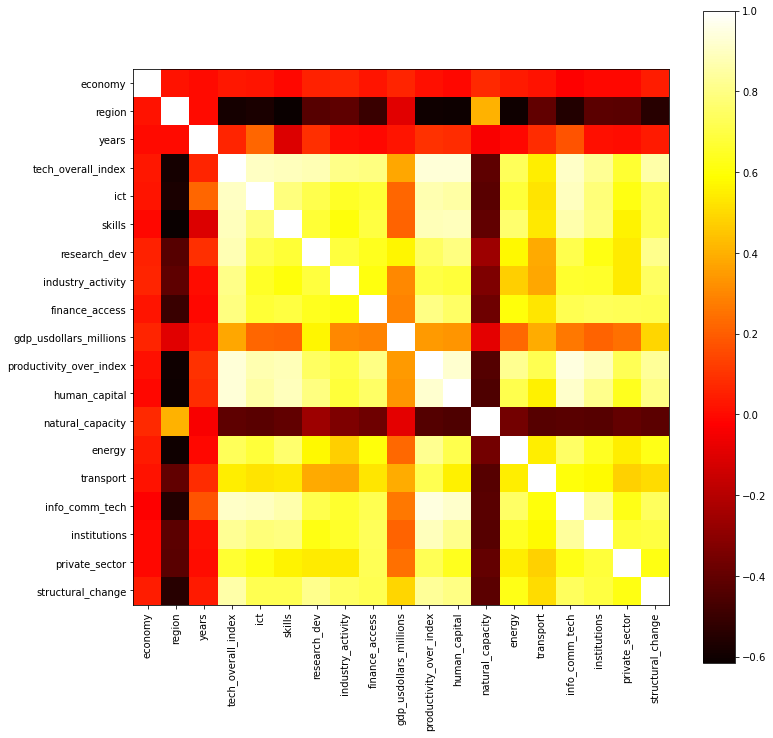

In [14]:
# Correlation Matrix heatmap for GDP_binary_encoded

corr_matrix= GDP_encoded.corr()
corr_matrix
fig_cor, axes_cor = plt.subplots(1,1)
fig_cor.set_size_inches(12, 12)

labels = summary_gdp.columns.tolist()

myimage = axes_cor.imshow(corr_matrix, cmap='hot', interpolation='nearest')

plt.colorbar(myimage)

axes_cor.set_xticks(np.arange(0,corr_matrix.shape[0], corr_matrix.shape[0]*1.0/len(labels)))
axes_cor.set_yticks(np.arange(0,corr_matrix.shape[1], corr_matrix.shape[1]*1.0/len(labels)))

axes_cor.set_xticklabels(labels,rotation=90, fontsize=10)
axes_cor.set_yticklabels(labels,fontsize=10)
axes_cor.set_xticklabels(labels)
axes_cor.set_yticklabels(labels)

plt.draw()
corr_matrix

## Model #1: Multivariate Linear Regression - analysis of sixteen economic factors for X and GDP for y

### Transforming Data for Linear Regression

In [15]:
# Dropping unique identifier and redundant features
linear_gdp = summary_gdp_df.drop(['country_code','coft_id', 'gdp_per_capita_usdollars', 'tech_overall_index', 'productivity_over_index'], axis=1)

In [16]:
# Binary encoding using Dummy Variable Encoding
## Using dummy variable will allow us to preserve data integrity as labe encoding will confuse model to believe there is some kind of order or hierarchy
GDP_binary = pd.get_dummies(linear_gdp, columns=["economy", "region", "years"])
GDP_binary.head()

,ict,skills,research_dev,industry_activity,finance_access,gdp_usdollars_millions,human_capital,natural_capacity,energy,transport,...,years_2009,years_2010,years_2011,years_2012,years_2013,years_2014,years_2015,years_2016,years_2017,years_2018
0,0.103354,0.170865,0.000000,0.331855,0.242233,10236.90159,31.094856,58.485536,22.258151,8.488684,...,0,0,0,0,0,0,0,0,0,0
1,0.079601,0.165315,0.000000,0.401368,0.308691,11595.13347,32.643189,58.328269,23.138830,8.760733,...,1,0,0,0,0,0,0,0,0,0
2,0.078095,0.156798,0.000000,0.435488,0.310786,14698.88968,33.306044,58.486524,23.272956,8.972955,...,0,1,0,0,0,0,0,0,0,0
3,0.087214,0.151915,0.000000,0.358647,0.323599,17350.69495,33.294867,58.243822,24.590893,8.958996,...,0,0,1,0,0,0,0,0,0,0
4,0.074048,0.154567,0.055488,0.343089,0.161664,19136.49934,34.443517,58.087595,24.901164,8.905547,...,0,0,0,1,0,0,0,0,0,0


In [17]:
GDP_binary.shape

(1705, 187)

In [18]:
# Creating the scaler instance for Scaling data
data_scaler = StandardScaler()

In [19]:
# Fitting the scaler
GDP_data_scaled = data_scaler.fit_transform(GDP_binary)
GDP_data_scaled[:5]

array([[-1.0630201 , -1.26595101, -1.00377256, -0.7525023 , -1.73168136,
        -0.26954716, -1.46547272,  0.74710157, -0.7341518 , -1.22861578,
        -1.27085087, -1.96913581, -2.67115942, -0.93993417, 12.40967365,
        -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 ,
        -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 ,
        -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 ,
        -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 ,
        -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 ,
        -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 ,
        -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 ,
        -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 ,
        -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 ,
        -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 ,
        -0.0805823 , -0.0805823 , -0.0805823 , -0.0

### Setting X and y values

In [20]:
X=GDP_binary.drop(['gdp_usdollars_millions'],axis=1)
y=GDP_binary['gdp_usdollars_millions']

In [21]:
# Use train_test_split to create training and testing data.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [22]:
# Create the model by using LinearRegression.
from sklearn.linear_model import LinearRegression
model = LinearRegression()

### Fitting model

In [23]:
# Fit the model to the training data, and calculate the scores for the training and testing data.
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

### Test and Training Score Results

In [24]:
# Predict the test set results
y_pred=model.predict(X_test)
print(y_pred)

[-7.01549222e+04  5.97427156e+05  2.09694795e+06  1.27234056e+05
  8.94099863e+04  4.01031862e+04 -7.61229264e+03 -2.96714690e+05
 -1.80460717e+04 -1.80336071e+04  7.43671921e+04  2.76752011e+06
  1.96108559e+05  6.86558889e+04  6.80000133e+04  4.37507159e+04
  1.23446961e+05  5.37233914e+06  4.62718150e+04  6.39193573e+04
 -3.46718144e+05 -1.22900112e+05  2.53147451e+04  1.09388412e+05
  2.21891549e+05  1.66104725e+05 -1.03061357e+05  2.87691436e+05
  7.00680660e+04  4.61692629e+05  4.40364853e+05  1.25794022e+06
  9.87674508e+04  5.33899546e+04 -1.90090571e+04  1.24909471e+05
 -2.59115942e+04  1.50627903e+06  1.46373805e+05  1.16377100e+05
 -4.76795551e+04  5.47255862e+05 -3.36805112e+04 -6.33709696e+04
 -6.12805008e+04  1.21831170e+05 -4.66986071e+04  1.61245999e+06
  2.95065599e+05 -2.91812285e+05 -9.16553821e+03  1.12040626e+05
  2.14021829e+06  2.04585548e+05  2.01315758e+04  5.86703485e+04
 -3.16200100e+05  2.45154916e+04  1.82473070e+05  1.56480350e+05
 -6.86501216e+03  6.85548

In [25]:
# Converting numpy array to df to search for y_pred GDP by index value
pred_array = y_pred
GDP_pred = pd.DataFrame(pred_array)
GDP_pred.loc[45]

0    121831.170398
Name: 45, dtype: float64

In [26]:
# r2_score for both Test and Training data

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.9700382481831892
Testing Score: 0.9823926876651037


Text(0.5, 1.0, 'Actual vs. Predicted')

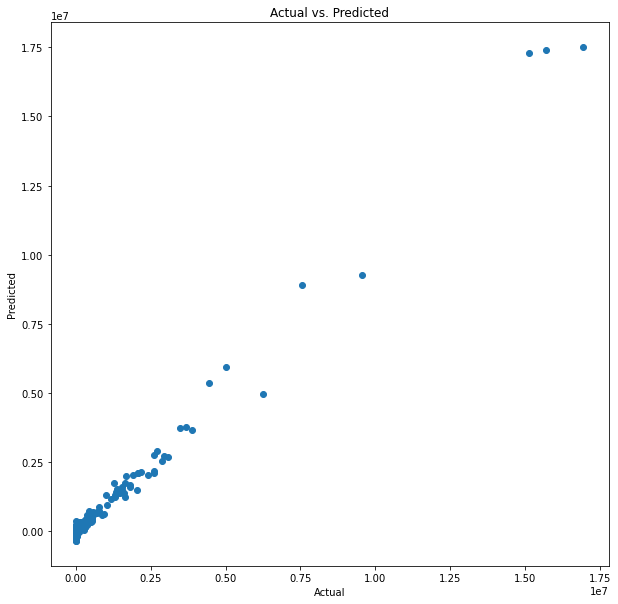

In [27]:
# Plotting Actual vs Predicted test values

plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

Text(0.5, 1.0, 'Actual vs. Difference')

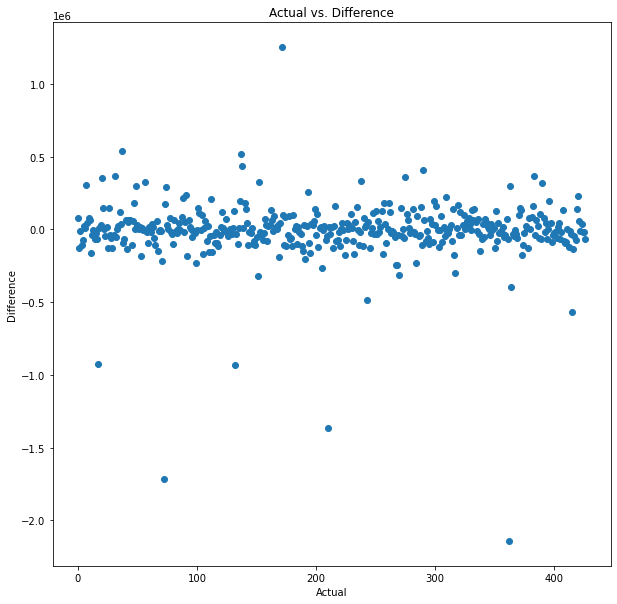

In [28]:
## Reset index 

pred_y_df=pd.DataFrame({'Actual Value':y_test, 'Predicted value':y_pred, 'Difference': y_test-y_pred})
pred_y_df.reset_index(inplace=True)
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(pred_y_df.index,pred_y_df.Difference)
plt.xlabel('Actual')
plt.ylabel('Difference')
plt.title('Actual vs. Difference')

## Model #2: Random Forest

In [32]:
# Creating Random Forest df (dropping indexes to avoid )
rf_gdp = GDP_encoded.drop(['tech_overall_index', 'productivity_over_index'], axis=1)
rf_gdp

,economy,region,years,ict,skills,research_dev,industry_activity,finance_access,gdp_usdollars_millions,human_capital,natural_capacity,energy,transport,info_comm_tech,institutions,private_sector,structural_change
0,0,5,2008,0.103354,0.170865,0.000000,0.331855,0.242233,10236.90159,31.094856,58.485536,22.258151,8.488684,3.577535,15.947558,54.600186,14.723942
1,0,5,2009,0.079601,0.165315,0.000000,0.401368,0.308691,11595.13347,32.643189,58.328269,23.138830,8.760733,3.879257,15.463749,53.510755,15.254662
2,0,5,2010,0.078095,0.156798,0.000000,0.435488,0.310786,14698.88968,33.306044,58.486524,23.272956,8.972955,3.836936,16.084957,51.441468,15.411381
3,0,5,2011,0.087214,0.151915,0.000000,0.358647,0.323599,17350.69495,33.294867,58.243822,24.590893,8.958996,4.160740,16.593136,51.107480,15.956214
4,0,5,2012,0.074048,0.154567,0.055488,0.343089,0.161664,19136.49934,34.443517,58.087595,24.901164,8.905547,4.308839,20.446555,51.082891,15.383048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700,154,6,2014,0.055848,0.173870,0.033890,0.307966,0.402475,19495.51963,36.609360,53.354918,18.090417,11.175905,6.004241,25.011301,54.870738,18.070516
1701,154,6,2015,0.192407,0.157911,0.086122,0.318435,0.380626,19963.12062,37.122268,53.444351,18.039870,13.354525,6.481303,27.626012,54.925469,17.953966
1702,154,6,2016,0.191800,0.156142,0.084610,0.297645,0.370459,20548.67807,37.595356,53.444547,18.039870,14.080024,6.447096,27.623928,54.806645,17.790780
1703,154,6,2017,0.272719,0.135707,0.107108,0.243774,0.378796,22040.90230,37.982348,53.592981,17.872891,14.073782,6.858564,27.636091,54.346980,18.278227


### Setting X and y values

In [33]:
# Set as x2
Xx = rf_gdp.drop(["gdp_usdollars_millions"], axis=1)
yy = rf_gdp["gdp_usdollars_millions"]

### Splitting test and training data and placing in model

In [34]:
Xx_Train, Xx_Test, yy_Train, yy_Test = train_test_split(Xx, yy, random_state=42)

### Standardizing and fitting model

In [35]:
scaler = StandardScaler().fit(Xx_Train)
X_train_scaled = scaler.transform(Xx_Train)
X_test_scaled = scaler.transform(Xx_Test)

In [36]:
clf = RandomForestRegressor(random_state=1, n_estimators=1000).fit(X_train_scaled, yy_Train)
print(f'Training Score: {clf.score(X_train_scaled, yy_Train)}')
print(f'Testing Score: {clf.score(X_test_scaled, yy_Test)}')

Training Score: 0.9932231190457224
Testing Score: 0.9867071623376877


In [37]:
feature_importances = clf.feature_importances_
feature_rank = pd.DataFrame(feature_importances)
feature_rank.sort_values(by=[0], ascending=False)

,0
5,0.909039
15,0.015851
9,0.015500
6,0.009322
12,0.008681
8,0.007439
11,0.006560
4,0.004913
10,0.004880
13,0.004468


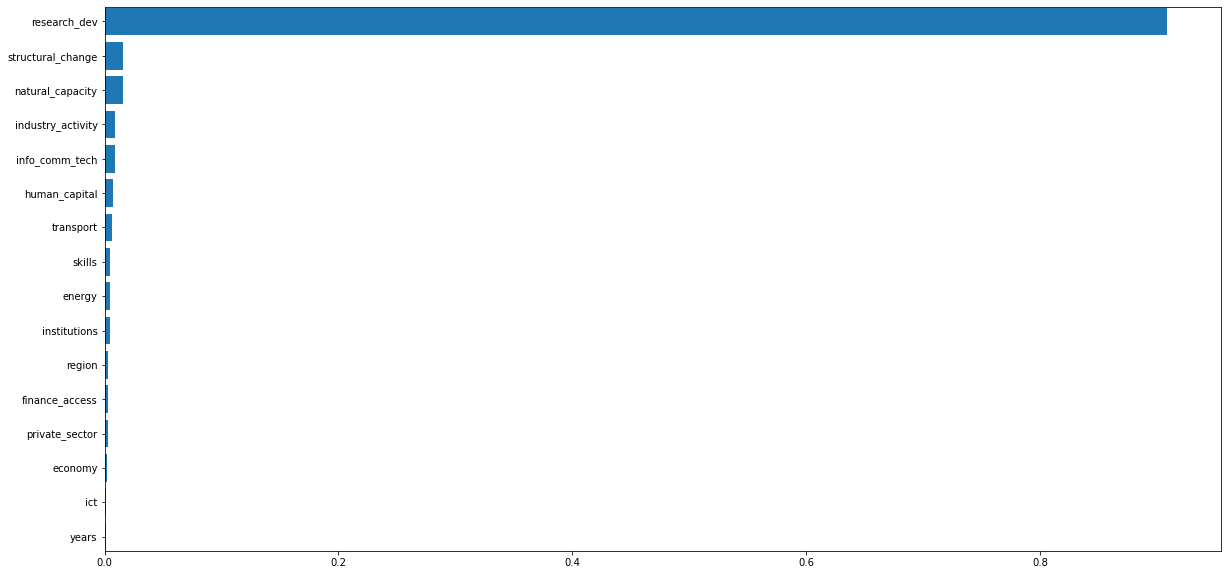

In [38]:
features = sorted(zip(Xx.columns, clf.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(20,10)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

## Permutation Test

In [39]:
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor

Xx = rf_gdp.drop(["gdp_usdollars_millions"], axis=1)
yy = rf_gdp["gdp_usdollars_millions"]

# Train Test Split
Xx_Train, Xx_Test, yy_Train, yy_Test = train_test_split(Xx, yy, random_state=42)

# Instantiate a Random Forest Regressor
regr = RandomForestRegressor(max_depth=100, random_state=0)

# Fit a random forest regressor
regr.fit(Xx_Train, yy_Train)


RandomForestRegressor(max_depth=100, random_state=0)

In [40]:
from sklearn.metrics import mean_squared_error

rmse_full_mod = mean_squared_error(regr.predict(Xx_Test), yy_Test, squared = False)
rmse_full_mod

197395.5877381493

In [41]:
# Initialize a list of results
results = []

# Iterate through each predictor
for predictor in Xx_Test:
    
    # Create a copy of X_test
    Xx_Test_copy = Xx_Test.copy()
    
    # Scramble the values of the given predictor
    Xx_Test_copy[predictor] = Xx_Test[predictor].sample(frac=1).values
    
    # Calculate the new RMSE
    new_rmse = mean_squared_error(regr.predict(Xx_Test_copy), yy_Test, squared = False)
    
    # Append the increase in MSE to the list of results 
    results.append({'pred': predictor,
                    'score': new_rmse - rmse_full_mod })

# Put the results into a pandas dataframe and rank the predictors by score
resultsdf = pd.DataFrame(results).sort_values(by = 'score', ascending = False)

In [42]:
resultsdf

,pred,score
5,research_dev,2.023181e+06
15,structural_change,1.158859e+05
6,industry_activity,8.100596e+04
9,natural_capacity,6.065738e+04
11,transport,5.503682e+04
8,human_capital,3.594957e+04
12,info_comm_tech,2.956894e+04
10,energy,2.947161e+04
4,skills,1.577734e+04
14,private_sector,1.280295e+04


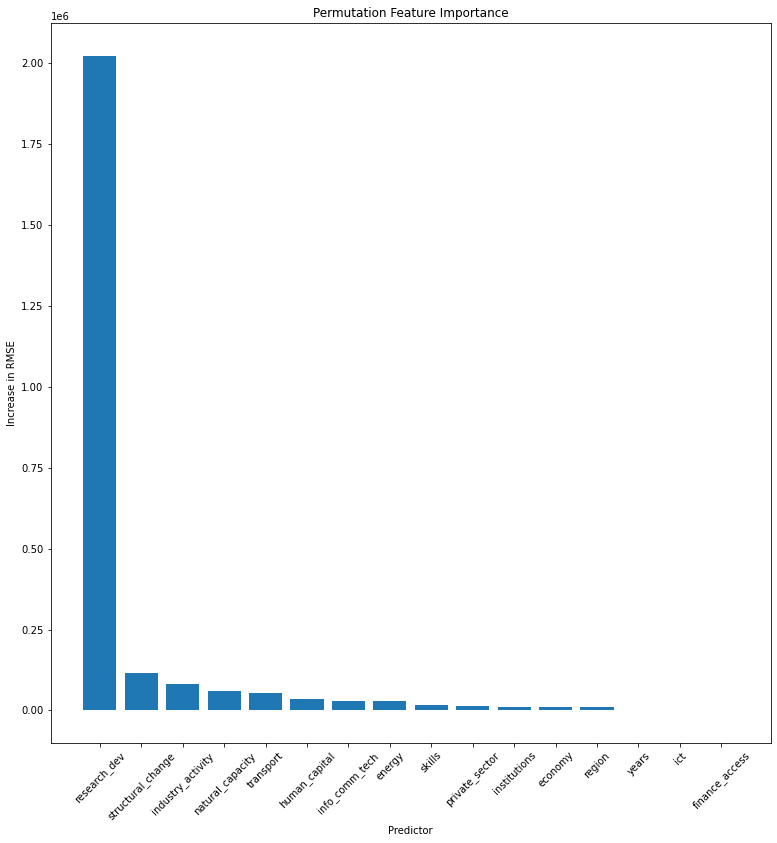

In [43]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Increase in RMSE')
ax.set_xlabel('Predictor')
ax.set_title('Permutation Feature Importance')

predictors = resultsdf.pred
y_pos = range(len(predictors))
scores = resultsdf.score
ax.bar(predictors,scores)
plt.xticks(y_pos, predictors, rotation=45)
plt.show()
